In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']

In [9]:
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [10]:
active_train_df = createDf(active_train)
active_binding_train_df =  createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')

In [11]:
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df =  createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')

In [12]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

0    649
1     58
Name: binding, dtype: int64


In [13]:
test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    73
1    20
Name: binding, dtype: int64


In [14]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)

In [94]:
final_train_set = pd.DataFrame(train_df.sequence, columns  =["sequence"])
final_train_set['binding'] = train_df.binding
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    649
1     58
Name: binding, dtype: int64
0    73
1    20
Name: binding, dtype: int64


In [95]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [96]:
print(training_split.shape)
print(test_split.shape)

(707, 81475)
(93, 81475)


In [97]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())
features

array(['10000', '10001', '10008', ..., '9998', '99988', '99989'],
      dtype=object)

In [98]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [99]:
training_split.shape

(707, 24442)

In [100]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [101]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [102]:
from sklearn.metrics import f1_score, accuracy_score
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    # print(f1_score(test_res, predicted))
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [103]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(3 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return new_train_data, new_train_res

In [104]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( 5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [192]:
from sklearn.tree import DecisionTreeClassifier

ensemble_size = 25
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print("========== iteration ========>",i)
        train_data, train_res = resample(training_split, train_result, weights)
        # print(sum(train_res))
        tree = DecisionTreeClassifier(max_depth= random.randint(1,3))
        tree.fit(train_data, train_res)
        print("percentage of ones:",sum(train_res)/len(train_res))
        predicted_result = tree.predict(training_split)

        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.2 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(tree)
        weights = updateWeight(error_indexes, weights, amount_of_say)
        # Rejection Sampling0
        # plt.plot(weights)
        # plt.show()

In [193]:

boosting(initial_weight)


========== iteration ========> 0
percentage of ones: 0.07807637906647807
0.9575671852899575
error_rate: 6.001812547389312e-05
1.0000000000000144
========== iteration ========> 1
percentage of ones: 0.47694483734087695
0.3069306930693069
error_rate: 0.0003235820319338473
0.9999999999999841
========== iteration ========> 2
percentage of ones: 0.0958981612446959
0.9603960396039604
error_rate: 7.125215785026898e-05
1.0000000000000269
========== iteration ========> 3
percentage of ones: 0.7196605374823196
0.2446958981612447
error_rate: 0.000331470049109494
1.0000000000000069
========== iteration ========> 4
percentage of ones: 0.10551626591230552
0.9292786421499293
error_rate: 7.046276726077876e-05
1.000000000000017
========== iteration ========> 5
percentage of ones: 0.7343705799151343
0.7397454031117398
error_rate: 0.00010811056181632281
1.0000000000000304
========== iteration ========> 6
percentage of ones: 0.8028288543140029
0.1272984441301273
error_rate: 0.00022565177235310739
0.999999

In [194]:
alphas

[1.9441607860408714,
 1.607146853093999,
 1.9098428397919798,
 1.6023283154033932,
 1.9120711292726675,
 1.8264496035113738,
 1.6792583800104464,
 1.7358944334270014,
 1.7402828045476857,
 1.6992995920466727,
 1.7563002312848615,
 1.7465991147304756,
 1.7304226662181899,
 1.7486164686196277,
 1.8901213224034141,
 1.6341231005564816,
 1.8076837699329573,
 1.623496146302318,
 1.8206324593172027,
 1.7908738043587,
 1.7977853930139673,
 1.723018272102917,
 1.8768342027013298,
 1.6435324003813443,
 1.7599982228501565]

In [195]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
f1=[]

def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    for i in range(start,end):
        data = some_pred(test_split, i)
    #     tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
    #     precision = tp / (tp+ fp)
    #     recall = tp / (tp+ fn)
    #     score = (2 * precision * recall) / (precision + recall)
    #     print(score)
    #     f1.append(score)
    #     if mx < score:
    #         mx = score
    #         size = i
    #     # print(i)
    # print(mx,size)
    return data

def some_pred(test_split, esize):
    data = []
    for j in range(len(test_split)):
        pa=0
        na =0
        for i in range(esize):
            k = ensemble[i].predict([test_split[j]])
            if k[0] == 1:
                pa += alphas[i]
            else:
                na+=alphas[i]
        if pa >=na:
            data.append(1)
        else:
            data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return data

In [196]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    return score

In [197]:
f1_test = []
acc_test = []
for i in range(1,ensemble_size+1):
    data = some_pred(test_split, i)
    f1_test.append(getf1(test_result, data))
    acc_test.append(accuracy_score(test_result, data))

In [198]:
f1_train = []
acc_train = []
for i in range(1,ensemble_size+1):
    data = some_pred(training_split, i)
    f1_train.append(getf1(train_result, data))
    acc_train.append(accuracy_score(train_result, data))

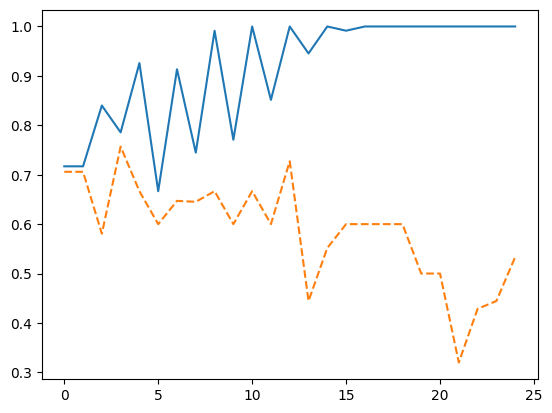

In [199]:
plt.plot(f1_train)
plt.plot(f1_test, '--')

In [188]:
f1_train[35]
# f1_test[35]

IndexError: list index out of range

In [189]:
acc_train[32]
# acc_test[32]

IndexError: list index out of range

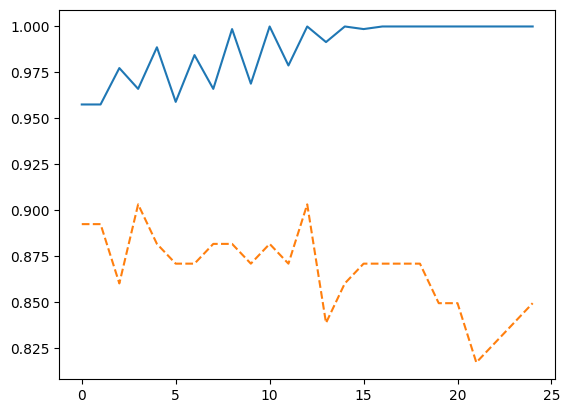

In [200]:
plt.plot(acc_train)
plt.plot(acc_test, '--')

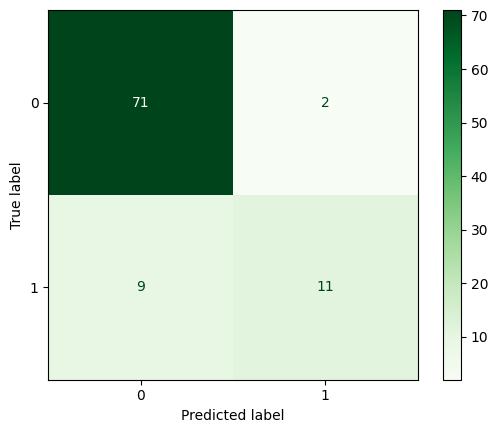

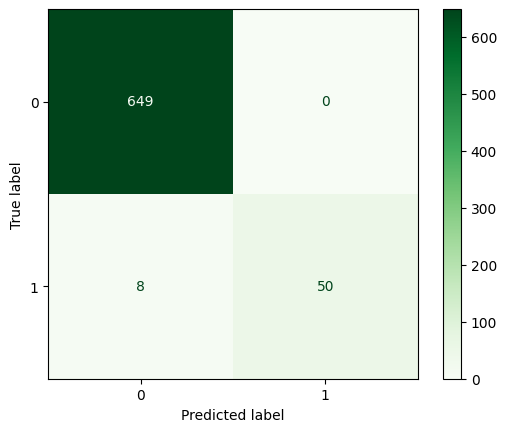

In [203]:
ConfusionMatrixDisplay.from_predictions(test_result,some_pred(test_split, 5),cmap='Greens')
ConfusionMatrixDisplay.from_predictions(train_result,some_pred(training_split, 5),cmap='Greens')

In [204]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()

predicted_data = some_pred(unlabeled_test, 5)

In [205]:
print(len(predicted_data))
print(unlabeled_test.shape)

350
(350, 24442)
